### Bộ dữ liệu Phân loại ảnh (Fashion MNIST)

- Mặc dù MNIST từng là bộ dữ liệu tốt để đánh giá xếp hạng, các mô hình đơn giản theo tiêu chuẩn ngày nay cũng có thể đạt được độ chính xác lên tới 95%. Điều này khiến cho nó không phù hợp cho việc phân biệt độ mạnh yếu của các mô hình, Ngày nay, MNIST được dùng trong các phép kiểm tra sơ bộ hơn là dùng để đánh giá xếp hạng.

In [87]:
from d2l import mxnet as d2l
from mxnet import gluon
import sys

d2l.use_svg_display()

#### Tải về bộ dữ liệu
- Gluon giúp việc tải và nạp bộ dữ liệu FashionMNIST vào bộ nhớ trở nên dễ dàng hơn với lớp FashionMNIST trong gluon.data.vision

In [88]:
mnist_train = gluon.data.vision.FashionMNIST(train = True)
mnist_test = gluon.data.vision.FashionMNIST(train = False)

In [89]:
len(mnist_train), len(mnist_test), type(mnist_train), type(mnist_test)

(60000,
 10000,
 mxnet.gluon.data.vision.datasets.FashionMNIST,
 mxnet.gluon.data.vision.datasets.FashionMNIST)

Các ảnh trong Fashion-MNIST tương ứng với các lớp: áo phông, quần dài, áo thun, váy, áo khoác, dép, áo sơ mi, giày thể thao, túi và giày cao gót. Hàm dưới đây giúp chuyển đối giá trị số thành tên của từng lớp.

In [90]:
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

In [91]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images"""
    figsize = (num_cols * scale, num_rows * scale)
    fig, axes = d2l.plt.subplots(nrows=num_rows, ncols=num_cols, figsize=figsize)
    axes = axes.flatten()

    for i, (ax, img) in enumerate(zip(axes, imgs)):
        ax.imshow(img.asnumpy())  # Use `imshow`, not `imgshow`
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles is not None:
            ax.set_title(titles[i])
    
    return axes


array([<AxesSubplot:title={'center':'pullover'}>,
       <AxesSubplot:title={'center':'ankle boot'}>,
       <AxesSubplot:title={'center':'shirt'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'dress'}>,
       <AxesSubplot:title={'center':'coat'}>,
       <AxesSubplot:title={'center':'coat'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'coat'}>,
       <AxesSubplot:title={'center':'bag'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'bag'}>,
       <AxesSubplot:title={'center':'ankle boot'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'pullover'}>,
       <AxesSubplot:title={'center':'pullover'}>,
       <AxesSubplot:title={'center':'ankle boot'}>,
       <AxesSubplot:title={'center':'dress'}>], dtype=object)

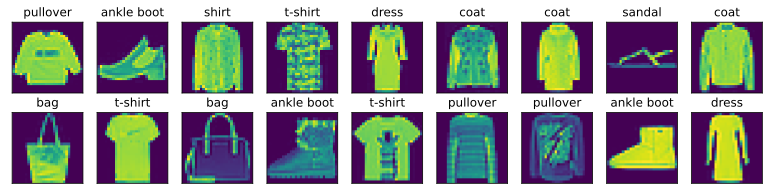

In [92]:
X, y = mnist_train[:18]

show_images(X.squeeze(axis = -1), 2, 9, titles = get_fashion_mnist_labels(y))

#### Đọc một minibatch
- Để đọc dữ liệu từ tập huấn luyện và tập kiểm tra một cách dễ dàng hơn, ta sử dụng một DataLoader có sẵn thay vì tạo từ đầu. Nhắc lại ở mỗi vòng lặp, một DataLoader sẽ đọc một minibatch của tập dữ liệu với kích thước batch_size.
- Trong quá trình huấn luyện, việc đọc dữ liệu có thể gây ra hiện tượng nghẽn cổ chai hiệu năng đáng kể. Một tính năng tiện dụng của DataLoader là khả năng sử dụng đa tiến trình để đọc dữ liệu (thông qua num_workers).

In [93]:
def get_dataloader_workers(num_workers = 4):
    # 0 means no additional process is used to speed up the reading of data
    if sys.platform.startswith('win'):
        return 0
    else:
        return num_workers

Dưới đây, ta chuyển dổi dữ liệu hình ảnh từ unit8 sang số thực dấu phẩy động 32 bit với lớp ToTensor. Ngoài ra, bộ chuyển đổi sẽ chia tất cả cho các số cho 255 để các điểm ảnh có giá trị từ 0 đến 1. Lớp ToTensor cũng sẽ chuyển kênh hình ảnh từ chiều cuối cùng sang chiều thứ nhất để tạo điều kiện cho các tình toán của mạng nơ ron tích chập sau này.
Thông qua hàm transform_first của tập dữ liệu, ta có thể áp dụng phép biến đổi ToTensor cho phần tử đầu tiên cuarm ỗi ví dụ (Mỗi ví dụ chứa hai phần tử là ảnh và nhãn)

In [94]:
batch_size = 256
transformer = gluon.data.vision.transforms.ToTensor()
train_iter = gluon.data.DataLoader(mnist_train.transform_first(transformer), batch_size, shuffle = True, num_workers=get_dataloader_workers())


In [95]:
timer = d2l.Timer()
for X, y in train_iter:
    continue
print(f"Total time use for reading training data: {timer.stop()} seconds") 

Total time use for reading training data: 4.785023927688599 seconds


#### Kết hợp tất cả lại với nhau
- Ta sẽ định nghĩa hàm load_data_fashion_mnist để nạp và đọc bỗ diwx liệu Fashon-MNIST. Hàm này trả về các iterator dữ liệu của cả tập huấn luyện và tập kiểm định. Thêm nữa, nó chấp nhận một tham số tùy chọn để thay đổi kích thước hình ảnh đầu vào.

In [96]:
def load_data_fashion_mnist(batch_size, resize = None):
    """Dowload the Fashion-MNIST dataset and then load into memory."""
    dataset = gluon.data.vision
    trans = [dataset.transforms.Resize(resize)] if resize is not None else []
    trans.append(dataset.transforms.ToTensor())

    # Sequentially composes multiple transforms.
    trans = dataset.transforms.Compose(trans) 

    mnist_train = dataset.FashionMNIST(train = True).transform_first(trans)
    mnist_test = dataset.FashionMNIST(train = False).transform_first(trans)

    return (gluon.data.DataLoader(mnist_train, batch_size, shuffle = True, num_workers=get_dataloader_workers()), 
            gluon.data.DataLoader(mnist_test, batch_size, shuffle = False, num_workers=get_dataloader_workers()))

(32, 1, 64, 64)

[9 6 1 4 9 3 6 6 5 8 0 5 1 5 9 7 5 6 8 8 3 2 6 3 7 4 9 7 3 3 7 9]
<NDArray 32 @cpu(0)>


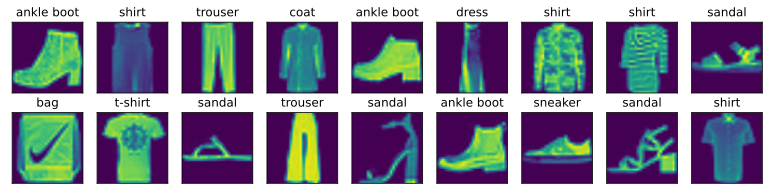

In [103]:
train_iter, test_iter = load_data_fashion_mnist(32, (64, 64))
for X, y in train_iter:
    print(X.shape)
    print(y)
    show_images(X.squeeze(axis = 1), 2, 9, get_fashion_mnist_labels(y.asnumpy()))
    break

